<a href="https://colab.research.google.com/github/copiglet/Carvana-Image-Masking-Challenge/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 압축 풀기

In [ ]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [ ]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [ ]:
train_zip = "./input/train.zip"
with ZipFile(train_zip, 'r') as zip_: 
    zip_.extractall('./working')
train_mask_zip = "./input/train_masks.zip"
with ZipFile(train_mask_zip, 'r') as zip_: 
    zip_.extractall('./working')

In [ ]:
print("Train set:  ", len(os.listdir("./working/train")))
print("Train masks:", len(os.listdir("./working/train_masks")))

Train set:   5088
Train masks: 5088


# 데이터 준비

In [ ]:
car_ids = []
paths = []
for dirname, _, filenames in os.walk('./working/train'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        car_id = filename.split(".")[0]
        car_ids.append(car_id)

d = {"id": car_ids, "car_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df

,car_path
id,
cf65b1c5e147_09,./working/train/cf65b1c5e147_09.jpg
cf65b1c5e147_10,./working/train/cf65b1c5e147_10.jpg
cf65b1c5e147_11,./working/train/cf65b1c5e147_11.jpg
cf65b1c5e147_12,./working/train/cf65b1c5e147_12.jpg
cf65b1c5e147_13,./working/train/cf65b1c5e147_13.jpg
...,...
0789bed99cb8_04,./working/train/0789bed99cb8_04.jpg
0789bed99cb8_05,./working/train/0789bed99cb8_05.jpg
0789bed99cb8_06,./working/train/0789bed99cb8_06.jpg


In [ ]:
car_ids = []
mask_path = []
for dirname, _, filenames in os.walk('./working/train_masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)
        
        car_id = filename.split(".")[0]
        car_id = car_id.split("_mask")[0]
        car_ids.append(car_id)

        
d = {"id": car_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df

,mask_path
id,
cf65b1c5e147_09,./working/train_masks/cf65b1c5e147_09_mask.gif
cf65b1c5e147_10,./working/train_masks/cf65b1c5e147_10_mask.gif
cf65b1c5e147_11,./working/train_masks/cf65b1c5e147_11_mask.gif
cf65b1c5e147_12,./working/train_masks/cf65b1c5e147_12_mask.gif
cf65b1c5e147_13,./working/train_masks/cf65b1c5e147_13_mask.gif
...,...
0789bed99cb8_04,./working/train_masks/0789bed99cb8_04_mask.gif
0789bed99cb8_05,./working/train_masks/0789bed99cb8_05_mask.gif
0789bed99cb8_06,./working/train_masks/0789bed99cb8_06_mask.gif


In [ ]:
df["mask_path"] = mask_df["mask_path"]
df

,car_path,mask_path
id,,
cf65b1c5e147_09,./working/train/cf65b1c5e147_09.jpg,./working/train_masks/cf65b1c5e147_09_mask.gif
cf65b1c5e147_10,./working/train/cf65b1c5e147_10.jpg,./working/train_masks/cf65b1c5e147_10_mask.gif
cf65b1c5e147_11,./working/train/cf65b1c5e147_11.jpg,./working/train_masks/cf65b1c5e147_11_mask.gif
cf65b1c5e147_12,./working/train/cf65b1c5e147_12.jpg,./working/train_masks/cf65b1c5e147_12_mask.gif
cf65b1c5e147_13,./working/train/cf65b1c5e147_13.jpg,./working/train_masks/cf65b1c5e147_13_mask.gif
...,...,...
0789bed99cb8_04,./working/train/0789bed99cb8_04.jpg,./working/train_masks/0789bed99cb8_04_mask.gif
0789bed99cb8_05,./working/train/0789bed99cb8_05.jpg,./working/train_masks/0789bed99cb8_05_mask.gif
0789bed99cb8_06,./working/train/0789bed99cb8_06.jpg,./working/train_masks/0789bed99cb8_06_mask.gif


# 데이터 전처리

In [ ]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["car_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [ ]:
train

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.float32)>

In [ ]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

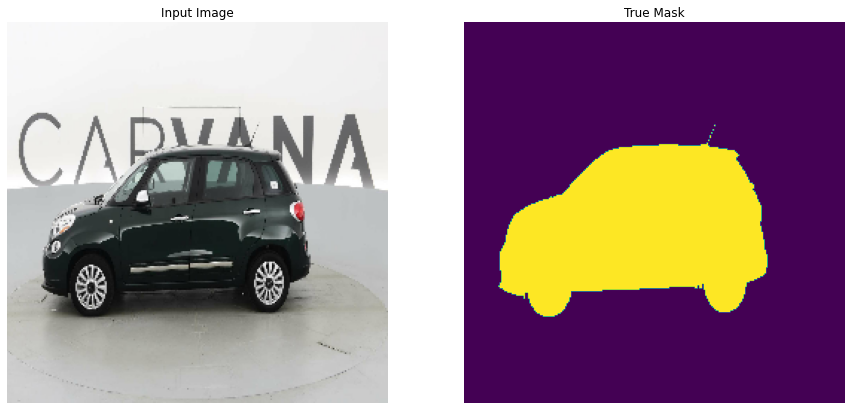

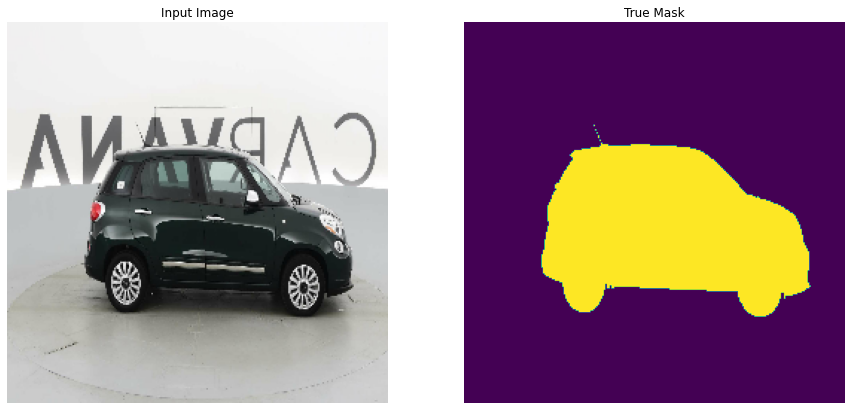

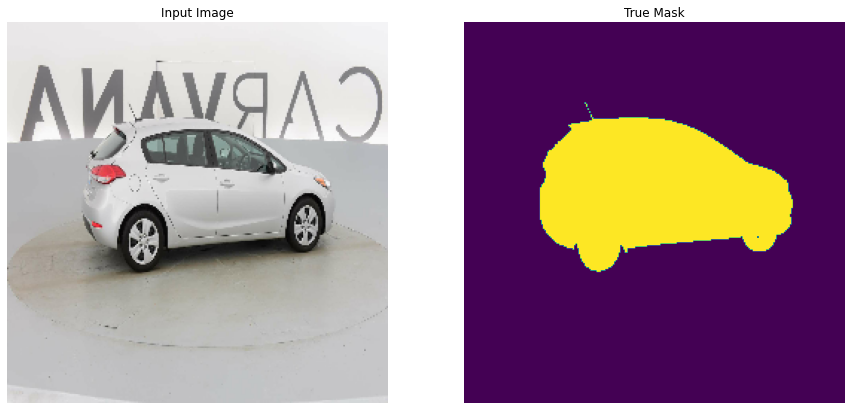

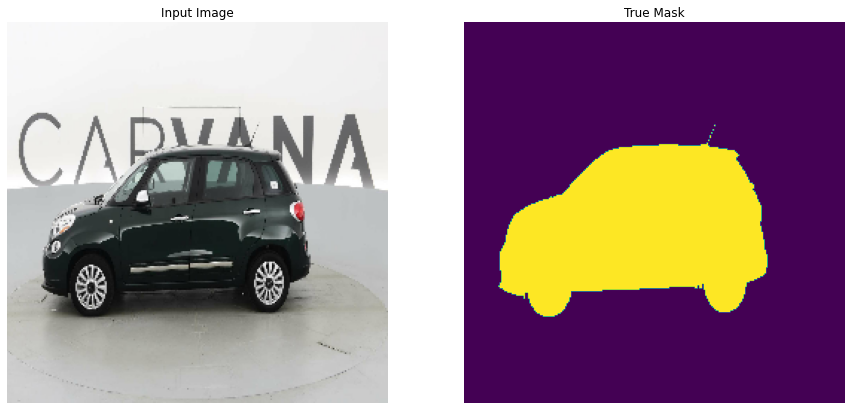

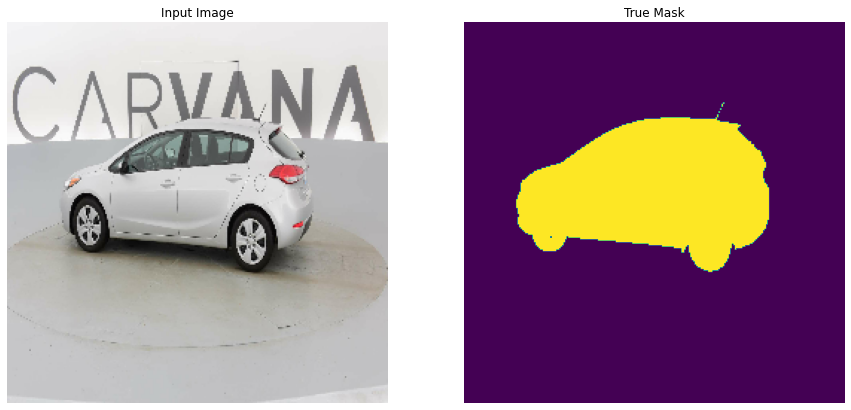

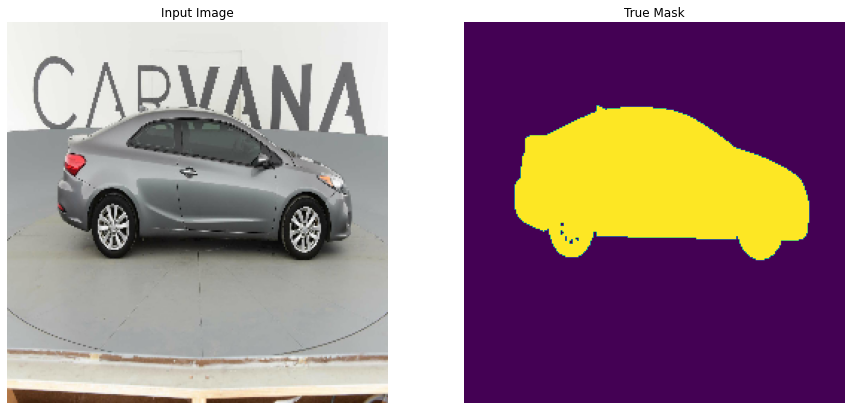

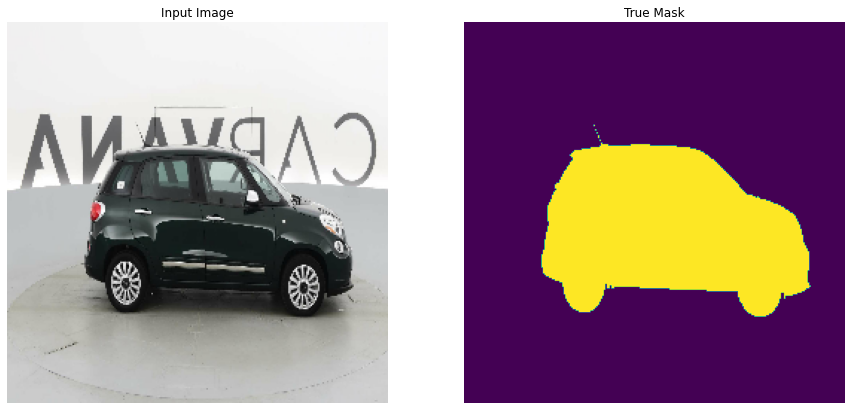

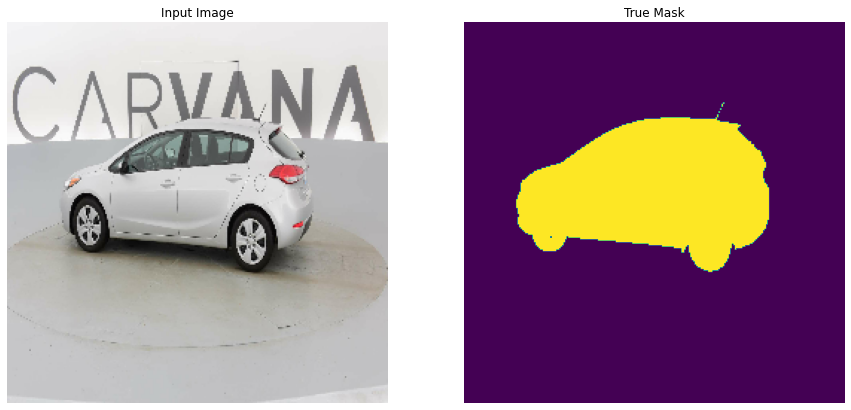

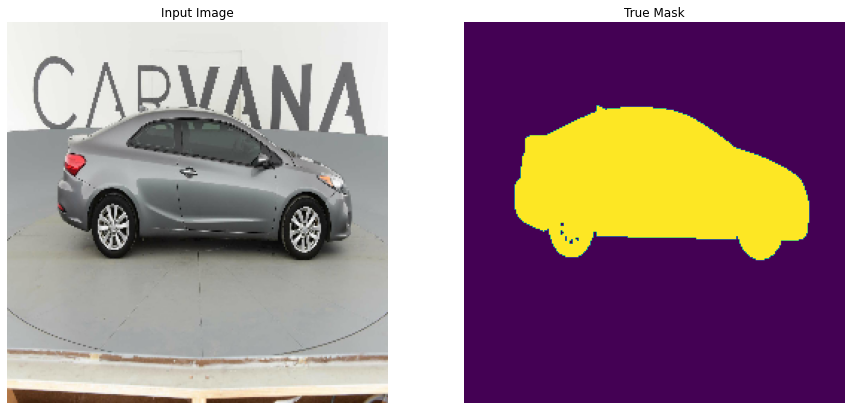

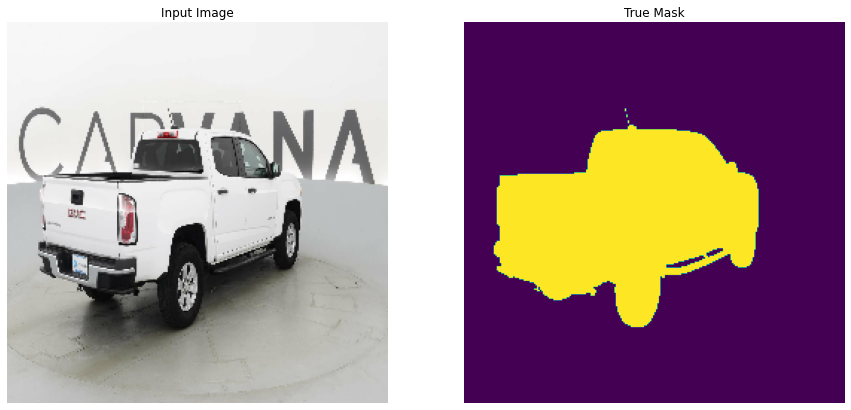

In [ ]:
for i in range(5):
   for image, mask in train.take(i): # take() 지정 행또는 열 가져옴
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

# 모델링

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# 이 층들의 활성화를 이용합니다
# 전이학습에 사용할 베이스 모델, 여기서 인코더 계층은 MobileNetV2입니다.
# 입력층 형태를 맞춰주고, 전이학습 커스텀을 할 완전연결층을 include_top 인자값을 사용해서 날려줍니다.
# 이 모델은 이미 충분히 학습되어 있기 때문에, 특징 출력 기능을 수행하는 계층으로만 사용할 것이며, 학습시에는 파인튜닝 외에는 동결을시킬 것입니다.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# 특징추출 모델을 만듭니다.
# 먼저, 동결시킬 아랫층의 레이어들을 묶어서 down_stack 모델을 만듭니다.
# Sequential은 단순해서 사용하기 쉽지만, 레이어를 순서로 직선형으로 차곡차곡 쌓는 것일 뿐, 복잡한 구조는 만들수 없습니다.
# keras.model 함수를 사용하면, 다중 입출력, 층 공유, 데이터 흐름 변경 등의 복잡한 모델 작성이 가능합니다.
# inputs에는 베이스 모델의 input을 주고, output은, 베이스 모델의 각 블록들을 택하여 리스트로 만들고, 그 output들을 model에 넣어줌으로써 해당 블록들에서 다중 출력을 하도록 합니다.
# 즉 input은, 베이스 모델 자체로 하고, output은, 총 5개의 클래스에서 반환되는 값을 사용합니다.
# 이를 동결하면 됩니다.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02) # 정규 분포로 텐서를 생성하는 이니셜 라이저 mean= 0 , stddev= 0.02
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    print(x)
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        print(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 320), dtype=tf.float32, name=None), name='model/block_16_project/Conv2D:0', description="created by layer 'model'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='sequential/batch_normalization/FusedBatchNormV3:0', description="created by layer 'sequential'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='sequential_1/batch_normalization_1/FusedBatchNormV3:0', description="created by layer 'sequential_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 128), dtype=tf.float32, name=None), name='sequential_2/batch_normalization_2/FusedBatchNormV3:0', description="created by layer 'sequential_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 64), dtype=tf.float32, name=None), name='sequential_3/batch_normalization_3/FusedBatchNormV3:0', description="created by layer 'sequential_3'")


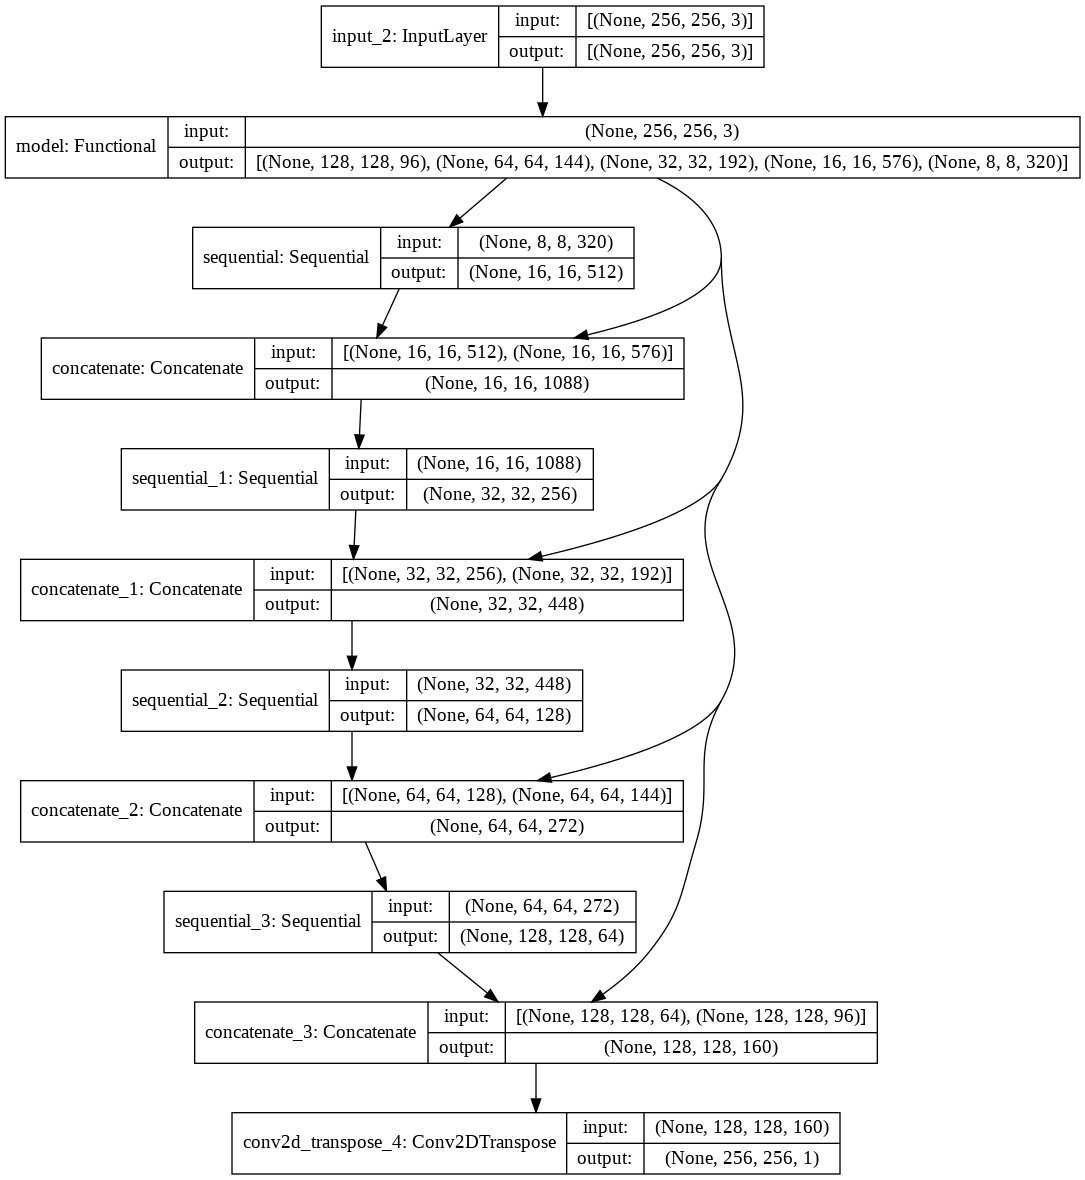

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

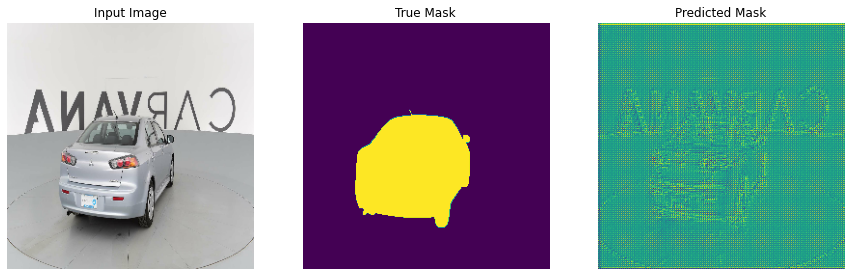

In [ ]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 512)  1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 16, 16, 1088) 0           sequential[0][0]                 
                                                                 model[0][3]                

Epoch 1/15
238/238 [==============================] - 1063s 4s/step - loss: 0.0709 - dice_coef: 0.9291 - binary_accuracy: 0.9712 - val_loss: 0.0288 - val_dice_coef: 0.9712 - val_binary_accuracy: 0.9901
Epoch 2/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0242 - dice_coef: 0.9758 - binary_accuracy: 0.9913 - val_loss: 0.0228 - val_dice_coef: 0.9772 - val_binary_accuracy: 0.9916
Epoch 3/15


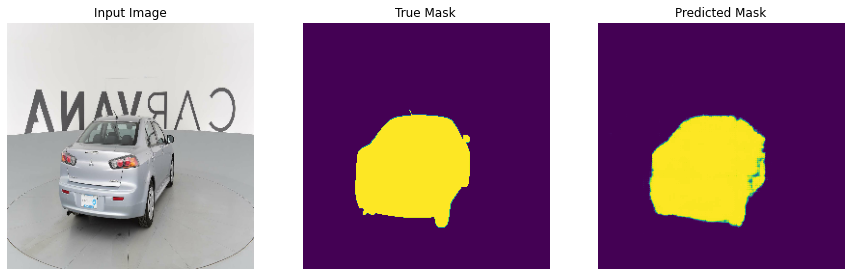

238/238 [==============================] - 28s 117ms/step - loss: 0.0215 - dice_coef: 0.9785 - binary_accuracy: 0.9919 - val_loss: 0.0208 - val_dice_coef: 0.9792 - val_binary_accuracy: 0.9919
Epoch 4/15
238/238 [==============================] - 28s 116ms/step - loss: 0.0202 - dice_coef: 0.9798 - binary_accuracy: 0.9922 - val_loss: 0.0199 - val_dice_coef: 0.9801 - val_binary_accuracy: 0.9922
Epoch 5/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0193 - dice_coef: 0.9806 - binary_accuracy: 0.9924 - val_loss: 0.0199 - val_dice_coef: 0.9801 - val_binary_accuracy: 0.9921
Epoch 6/15


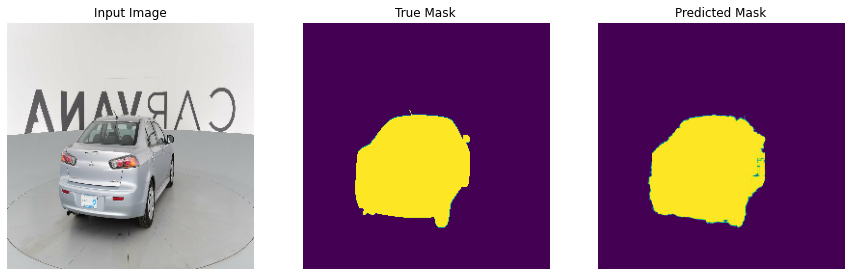

238/238 [==============================] - 28s 117ms/step - loss: 0.0186 - dice_coef: 0.9814 - binary_accuracy: 0.9926 - val_loss: 0.0196 - val_dice_coef: 0.9804 - val_binary_accuracy: 0.9922
Epoch 7/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0182 - dice_coef: 0.9818 - binary_accuracy: 0.9927 - val_loss: 0.0188 - val_dice_coef: 0.9812 - val_binary_accuracy: 0.9924
Epoch 8/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0180 - dice_coef: 0.9820 - binary_accuracy: 0.9928 - val_loss: 0.0189 - val_dice_coef: 0.9811 - val_binary_accuracy: 0.9924
Epoch 9/15


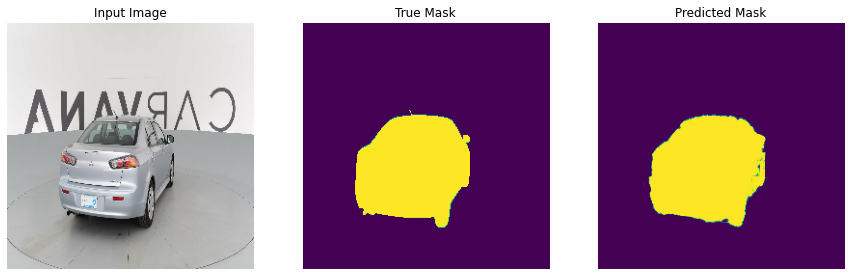

238/238 [==============================] - 28s 117ms/step - loss: 0.0176 - dice_coef: 0.9823 - binary_accuracy: 0.9928 - val_loss: 0.0184 - val_dice_coef: 0.9816 - val_binary_accuracy: 0.9925
Epoch 10/15
238/238 [==============================] - 28s 116ms/step - loss: 0.0174 - dice_coef: 0.9826 - binary_accuracy: 0.9929 - val_loss: 0.0181 - val_dice_coef: 0.9819 - val_binary_accuracy: 0.9926
Epoch 11/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0172 - dice_coef: 0.9828 - binary_accuracy: 0.9930 - val_loss: 0.0184 - val_dice_coef: 0.9816 - val_binary_accuracy: 0.9924
Epoch 12/15


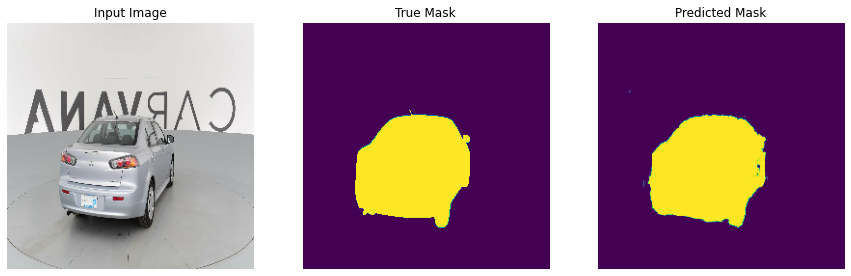

238/238 [==============================] - 28s 117ms/step - loss: 0.0170 - dice_coef: 0.9830 - binary_accuracy: 0.9930 - val_loss: 0.0181 - val_dice_coef: 0.9819 - val_binary_accuracy: 0.9926
Epoch 13/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0168 - dice_coef: 0.9832 - binary_accuracy: 0.9931 - val_loss: 0.0182 - val_dice_coef: 0.9818 - val_binary_accuracy: 0.9925
Epoch 14/15
238/238 [==============================] - 28s 117ms/step - loss: 0.0166 - dice_coef: 0.9834 - binary_accuracy: 0.9932 - val_loss: 0.0179 - val_dice_coef: 0.9821 - val_binary_accuracy: 0.9926
Epoch 15/15


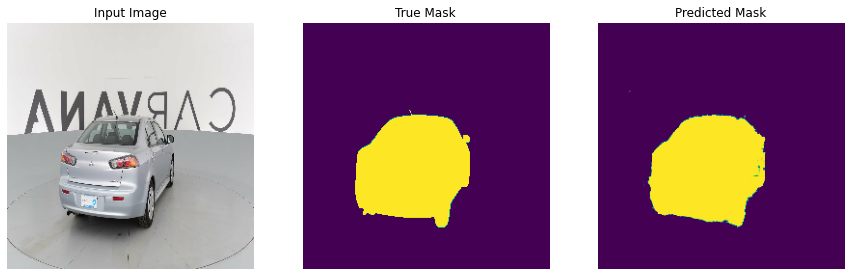

238/238 [==============================] - 28s 117ms/step - loss: 0.0165 - dice_coef: 0.9835 - binary_accuracy: 0.9932 - val_loss: 0.0185 - val_dice_coef: 0.9815 - val_binary_accuracy: 0.9924


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True) #epoch 중에서 metric 성능이 가장 좋은 모델이 복구
 
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 15
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

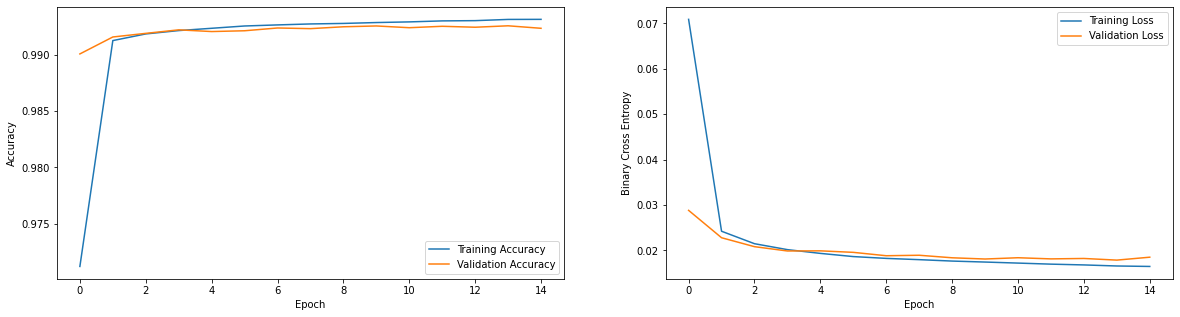

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

acc = model_history.history['binary_accuracy']
val_acc = model_history.history['val_binary_accuracy']

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy')
plt.legend()
plt.show()